In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
links = pd.read_csv('/Users/mamolchanova/Documents/Обучение/ML/15 Занятие - рекомендательные системы/links.csv')
movies = pd.read_csv('/Users/mamolchanova/Documents/Обучение/ML/15 Занятие - рекомендательные системы/movies.csv')
ratings = pd.read_csv('/Users/mamolchanova/Documents/Обучение/ML/15 Занятие - рекомендательные системы/ratings.csv')
tags = pd.read_csv('/Users/mamolchanova/Documents/Обучение/ML/15 Занятие - рекомендательные системы/tags.csv')

In [3]:
# соединим таблицу с рейтингами и названиями фильмов
joined_ratings = ratings.join(movies.set_index('movieId'), on='movieId')

In [4]:
joined_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


# Составление рейтинга для жанра Action

In [5]:
df=joined_ratings[joined_ratings['genres'].str.contains('Action')]
df.head()

,userId,movieId,rating,timestamp,title,genres
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
10,1,163,5.0,964983650,Desperado (1995),Action|Romance|Western


Т.к. нам в будущем нужно будет одни и те же операции применять к двум жанрам, оформлю всё сразу в виде функций.
Мне стало интересно составить 3 популярных вида рейтинга и посмотреть, насколько похожие они выдают результаты. Я использвала рейтинг, рассмотренный на занятии, рейтинг для кинопоиска и рейтинг на основе метода взвешенной суммы критериев.

In [6]:
# т.к. я буду работать только с 2мя показателями, переведу таблицу в удобный вид
def score_summerize(df):
    groupby_df = df.groupby("title")
    df_grouped=groupby_df.agg({"rating": "mean", "title": "count"}).rename({'title': 'count', 'rating': 'score'}, axis=1)
    return df_grouped

In [7]:
df_grouped=score_summerize(df)

In [8]:
df_grouped.head()

,score,count
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
"10th Victim, The (La decima vittima) (1965)",4.0,1
12 Rounds (2009),3.0,3
13 Assassins (Jûsan-nin no shikaku) (2010),4.0,4


In [9]:
# рассчитаю все нужные для работы показатели
# для кинопоиска нужен порог голосов, необходимых для участия в рейтинге. В качестве порога я взяла третью квартиль

def calc_key_indicators(df):
    key_indicators={
        "count_quantile_75": df['count'].quantile(.75),
        "df_score_mean": df['score'].mean(),
        "df_score_max": df['score'].max(),
        "df_count_max": df['count'].max(),
        "df_count_mean": df['count'].mean(),
        "df_count_min": df['count'].min()
    }
    return key_indicators

In [10]:
df_ki=calc_key_indicators(df_grouped)

In [11]:
df_ki

{'count_quantile_75': 18.0,
 'df_score_mean': 3.0945470147228393,
 'df_score_max': 5.0,
 'df_count_max': 278,
 'df_count_mean': 16.76792556102901,
 'df_count_min': 1}

In [12]:
def calc_rating_kinopoisk(df):
    df['rating_kinopoisk']=df['count']/(df['count']+df_ki['count_quantile_75'])*df['score']+df_ki['count_quantile_75']/(df['count']+df_ki['count_quantile_75'])*df_ki['df_score_mean']
    return df

In [13]:
df_grouped=calc_rating_kinopoisk(df_grouped)

In [14]:
def calc_rating_mvsk(df):
    df['rating_mvsk']=0.45*df['score']/df_ki['df_score_max']+0.55*df['count']/df_ki['df_count_max']
    return df

In [15]:
df_grouped=calc_rating_mvsk(df_grouped)

In [16]:
def calc_rating_default(df):
    df['rating_default']=df['score']*(df['count']-df_ki['df_count_mean'])/(df_ki['df_count_max']-df_ki['df_count_min'])
    return df

In [17]:
df_grouped=calc_rating_default(df_grouped)

In [18]:
def calc_ranks(df):
    df["rank_kinopoisk"] = df["rating_kinopoisk"].rank(ascending=False)
    df["rank_mvsk"] = df["rating_mvsk"].rank(ascending=False)
    df["rank_default"] = df["rating_default"].rank(ascending=False)
    return df

In [19]:
df_grouped=calc_ranks(df_grouped)

In [20]:
#теперь можем вывести фильмы по любому рейтингу. Например, по тому, который использовался на занятии

df_grouped.sort_values(by="rating_default", inplace=True, ascending=False)
df_grouped.head(10)

,score,count,rating_kinopoisk,rating_mvsk,rating_default,rank_kinopoisk,rank_mvsk,rank_default
title,,,,,,,,
"Matrix, The (1999)",4.192446,278,4.125682,0.927320,3.953796,4.0,1.0,1.0
Star Wars: Episode IV - A New Hope (1977),4.231076,251,4.155025,0.877380,3.577811,2.0,2.0,2.0
Braveheart (1995),4.031646,237,3.965497,0.831733,3.205407,13.0,3.0,3.0
Fight Club (1999),4.272936,218,4.183059,0.815859,3.104158,1.0,4.0,4.0
Jurassic Park (1993),3.750000,238,3.703913,0.808363,2.995019,69.0,5.0,5.0
Terminator 2: Judgment Day (1991),3.970982,224,3.905793,0.800554,2.970812,21.0,6.0,6.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.215640,211,4.127519,0.796854,2.956002,3.0,7.0,7.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.207500,200,4.115605,0.774358,2.783209,5.0,8.0,8.0
Star Wars: Episode VI - Return of the Jedi (1983),4.137755,196,4.050009,0.760168,2.677323,10.0,9.0,9.0


Дополнительно можно изучить насколько сильно отличаются рейтинги

In [21]:
def calc_rank_difference(df):
    df['rank_diff_km']=abs(df['rank_kinopoisk']-df['rank_mvsk'])
    df['rank_diff_kd']=abs(df['rank_kinopoisk']-df['rank_default'])
    df['rank_diff_md']=abs(df['rank_mvsk']-df['rank_default'])
    return df

In [22]:
df_grouped=calc_rank_difference(df_grouped)

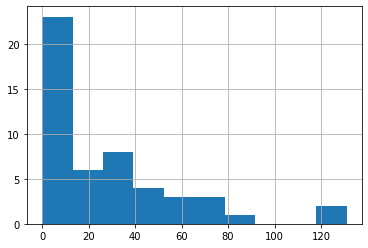

In [23]:
df_grouped.loc[df_grouped['rank_kinopoisk'] <= 50]["rank_diff_km"].hist()

In [24]:
df_grouped.loc[df_grouped['rank_kinopoisk'] <= 50]["rank_diff_km"].mean()

28.44

Отличие между рейтингом для кинопоиска и МВСК существенное

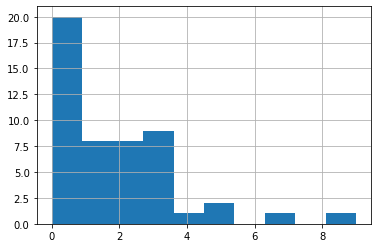

In [25]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].hist()

In [26]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].mean()

1.62

In [27]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].std()

1.94715910275164

А вот метод МВСК ведет себя похожим образом с методом, рассмотренным на занятии для первых 50 записей.

# Составление рейтинга для жанра Comedy

In [28]:
df=joined_ratings[joined_ratings['genres'].str.contains('Comedy')]
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [29]:
df_grouped=score_summerize(df)

In [30]:
df_ki=calc_key_indicators(df_grouped)
df_ki

{'count_quantile_75': 9.0,
 'df_score_mean': 3.1815048623080564,
 'df_score_max': 5.0,
 'df_count_max': 329,
 'df_count_mean': 10.408582089552239,
 'df_count_min': 1}

In [31]:
df_grouped=calc_rating_kinopoisk(df_grouped)

In [32]:
df_grouped=calc_rating_mvsk(df_grouped)

In [33]:
df_grouped=calc_rating_default(df_grouped)

In [34]:
df_grouped=calc_rating_default(df_grouped)

In [35]:
df_grouped=calc_ranks(df_grouped)

In [36]:
df_grouped.sort_values(by="rating_default", inplace=True, ascending=False)
df_grouped.head(10)

,score,count,rating_kinopoisk,rating_mvsk,rating_default,rank_kinopoisk,rank_mvsk,rank_default
title,,,,,,,,
Forrest Gump (1994),4.164134,329,4.137969,0.924772,4.044687,4.0,1.0,1.0
Pulp Fiction (1994),4.197068,307,4.168144,0.890958,3.795166,3.0,2.0,2.0
Toy Story (1995),3.920930,215,3.891221,0.712306,2.445697,32.0,3.0,3.0
Fargo (1996),4.116022,181,4.071755,0.673026,2.140726,7.0,4.0,4.0
Aladdin (1992),3.792350,183,3.763716,0.647239,1.995509,95.0,6.0,5.0
Back to the Future (1985),4.038012,171,3.995186,0.649287,1.977043,13.0,5.0,6.0
Shrek (2001),3.867647,170,3.833148,0.632283,1.881839,53.0,7.0,7.0
True Lies (1994),3.497191,178,3.481998,0.612316,1.786888,366.0,9.0,8.0
"Princess Bride, The (1987)",4.232394,142,4.169759,0.618302,1.698008,2.0,8.0,9.0


In [37]:
df_grouped=calc_rank_difference(df_grouped)

In [38]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].mean()

4.68

In [39]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].std()

4.858991244936272

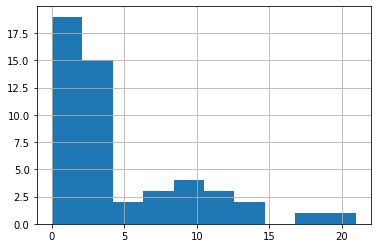

In [40]:
df_grouped.loc[df_grouped['rank_mvsk'] <= 50]["rank_diff_md"].hist()

Для другого жанра различие стало больше